## Network Analysis

To analyze social network structures and use machine learning to predict influential nodes or communities based on network features. This will involve extracting network metrics, training a model, and evaluating the network's dynamics.

In [64]:
import os
import networkx as nx
import pandas as pd
from joblib import Parallel, delayed
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [65]:
import os
import networkx as nx

data_folder = "/Users/abiramiravishankar/Downloads/facebook"  # Adjust with your actual path

ego_networks = {}

for file in os.listdir(data_folder):
    if file.endswith(".edges"):
        edges_file = os.path.join(data_folder, file)
        
        G = nx.read_edgelist(edges_file, create_using=nx.Graph(), nodetype=int)
        
        ego_networks[file.split(".")[0]] = G

if ego_networks:
    sample_network = list(ego_networks.keys())[0]
    print(f"Info for {sample_network} Ego Network:")
    print(f"Number of nodes: {ego_networks[sample_network].number_of_nodes()}")
    print(f"Number of edges: {ego_networks[sample_network].number_of_edges()}")
else:
    print("No ego networks were loaded. Please check if the '.edges' files exist.")


Info for 686 Ego Network:
Number of nodes: 168
Number of edges: 1656


In [66]:
limited_networks = dict(list(ego_networks.items())[:5])

all_features = pd.DataFrame()

for ego_id, G in limited_networks.items():
    features = pd.DataFrame({
        'node': list(G.nodes),
        'degree': [val for (node, val) in G.degree()],
        'clustering': [nx.clustering(G, node) for node in G.nodes]
    })
    features['network'] = ego_id
    all_features = pd.concat([all_features, features], ignore_index=True)

all_features.head()


,node,degree,clustering,network
0,827,44,0.451374,686
1,819,35,0.500840,686
2,830,51,0.410196,686
3,826,10,0.555556,686
4,828,77,0.314081,686


In [67]:
# Label nodes as influential if clustering coefficient > 0.5
all_features_df['influential'] = all_features_df['clustering'].apply(lambda x: 1 if x > 0.5 else 0)
all_features_df['influential'].value_counts()

influential
1    2406
0    1683
Name: count, dtype: int64

In [68]:
# Define features (X) and label (y)
X = all_features_df[['degree', 'clustering']]
y = all_features_df['influential']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [69]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00       694

    accuracy                           1.00      1227
   macro avg       1.00      1.00      1.00      1227
weighted avg       1.00      1.00      1.00      1227

Accuracy: 0.9991850040749797


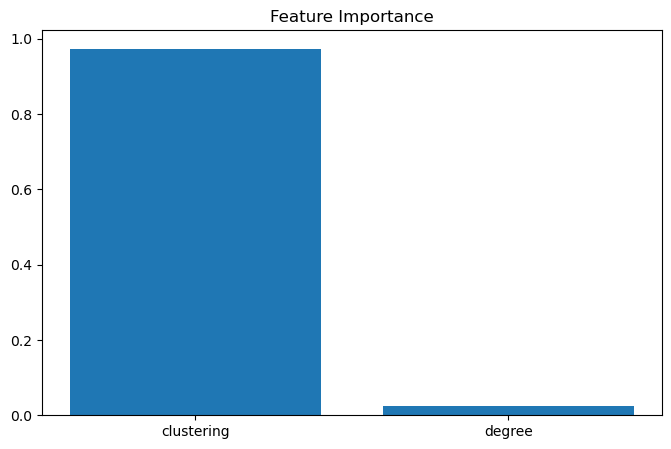

In [70]:
# Feature importance plot
importances = model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importance")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.show()


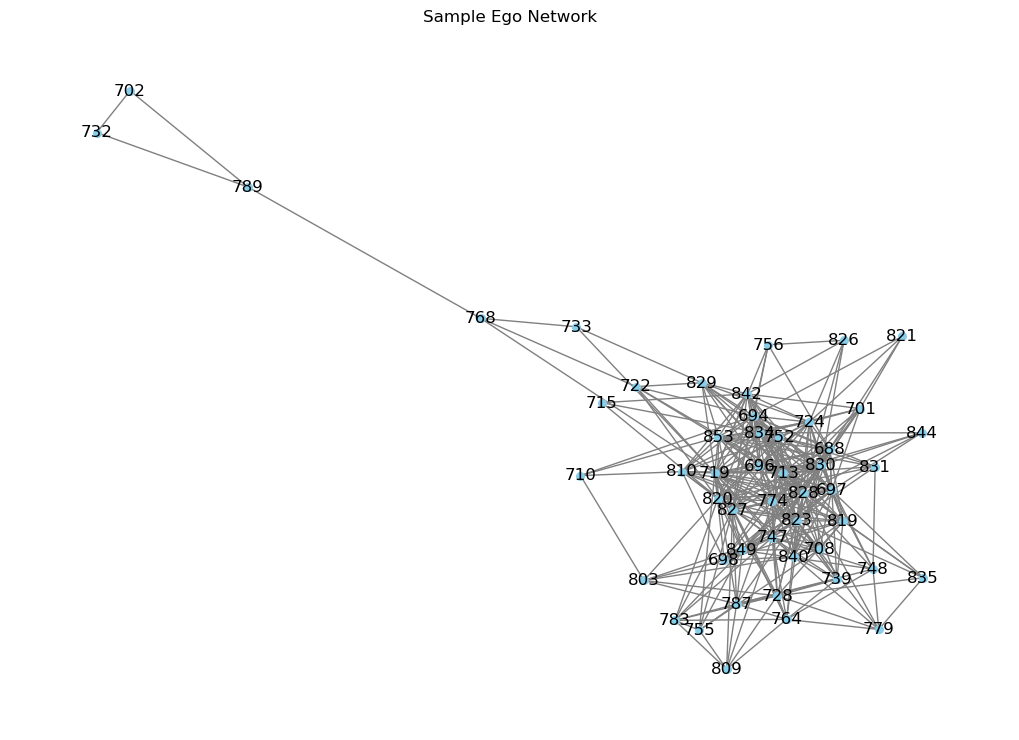

In [71]:
# Visualize a small subgraph from a sample network
sample_network = ego_networks[sample_network]  # Replace with any network ID as needed
sample_nodes = list(sample_network.nodes)[:50]  # Take a subset of nodes for visualization
sample_subgraph = sample_network.subgraph(sample_nodes)

plt.figure(figsize=(10, 7))
nx.draw(sample_subgraph, with_labels=True, node_size=30, node_color="skyblue", edge_color="gray")
plt.title("Sample Ego Network")
plt.show()


In [76]:
from networkx.algorithms.community import girvan_newman

# Select a sample network by its ID
sample_network_id = list(ego_networks.keys())[0]  # Pick the first network ID or any other
sample_network = ego_networks[sample_network_id]  # Get the actual graph

# Use the Girvan-Newman algorithm to find communities
communities = girvan_newman(sample_network)
top_level_communities = next(communities)
community_mapping = {node: cid for cid, community in enumerate(top_level_communities) for node in community}

# Add community information to the DataFrame
all_features_df['community'] = all_features_df['node'].map(community_mapping).fillna(-1).astype(int)
all_features_df[['node', 'community']].head()


,node,community
0,827,0
1,819,0
2,830,0
3,826,0
4,828,0


In [77]:
# Calculate additional centrality measures
for ego_id, G in ego_networks.items():
    # Closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    # Eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=100)
    
    # Update DataFrame with new centrality metrics
    for node, row in all_features_df[all_features_df['network'] == ego_id].iterrows():
        all_features_df.at[node, 'closeness'] = closeness_centrality.get(row['node'], 0)
        all_features_df.at[node, 'eigenvector'] = eigenvector_centrality.get(row['node'], 0)

all_features_df.head()


,node,degree,clustering,network,influential,community,closeness,eigenvector
0,827,44,0.451374,686,0,0,0.510703,0.141067
1,819,35,0.500840,686,1,0,0.506061,0.111792
2,830,51,0.410196,686,0,0,0.528481,0.160755
3,826,10,0.555556,686,1,0,0.415423,0.034933
4,828,77,0.314081,686,0,0,0.594306,0.214428


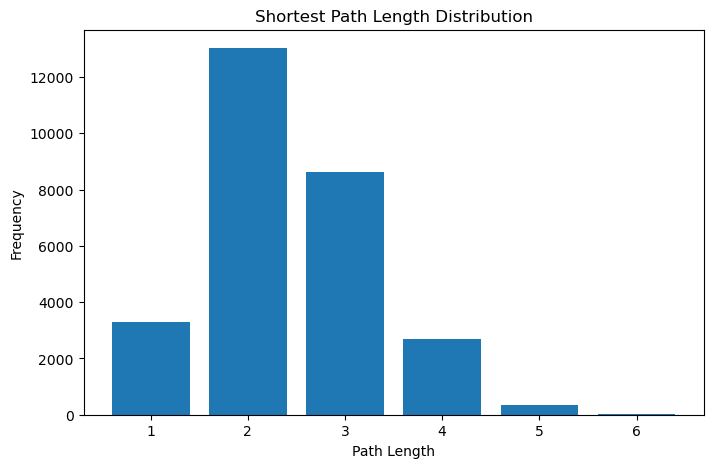

In [78]:
# Shortest path length distribution in the sample network
from collections import Counter

path_lengths = dict(nx.shortest_path_length(sample_network))
length_counts = Counter()

# Count all path lengths between pairs of nodes
for source, targets in path_lengths.items():
    for target, length in targets.items():
        if source != target:
            length_counts[length] += 1

# Plot the distribution of shortest path lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(length_counts.keys(), length_counts.values())
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.title("Shortest Path Length Distribution")
plt.show()


In [82]:
# Calculate network density and average clustering for each ego network
network_stats = []

for ego_id, G in ego_networks.items():
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G)
    network_stats.append({'network': ego_id, 'density': density, 'average_clustering': avg_clustering})

# Convert the list of dictionaries to a DataFrame
network_stats_df = pd.DataFrame(network_stats)

# Display the DataFrame
network_stats_df


,network,density,average_clustering
0,686,0.118050,0.533791
1,348,0.127803,0.544281
2,3437,0.033820,0.543725
3,1912,0.107759,0.635405
4,1684,0.045458,0.475730
5,0,0.045570,0.508245
6,698,0.147541,0.733202
7,3980,0.110106,0.461727
8,414,0.151499,0.670292
9,107,0.050086,0.526405


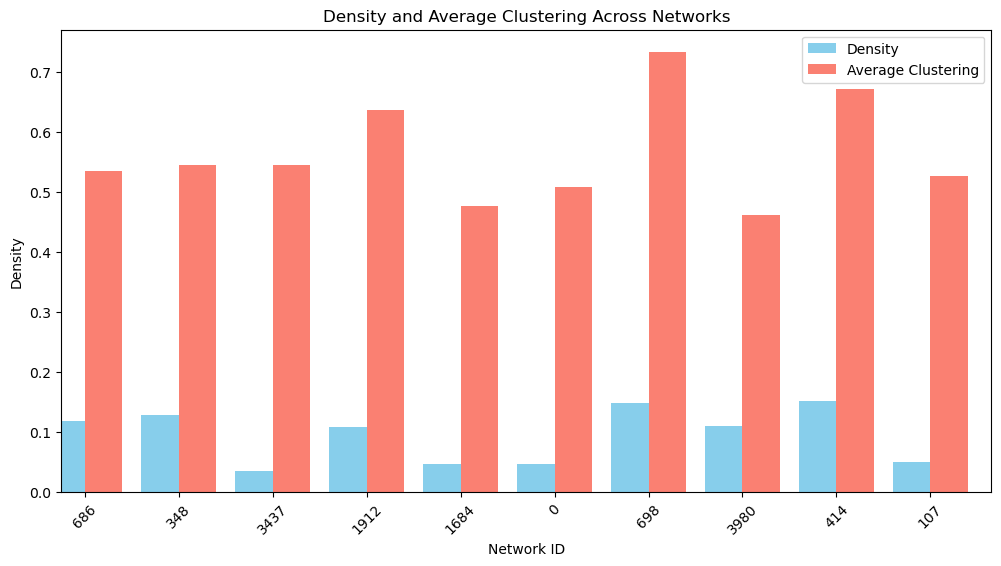

In [83]:
import matplotlib.pyplot as plt

# Plot density and average clustering for each network
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for density
network_stats_df.plot(x='network', y='density', kind='bar', ax=ax1, color='skyblue', position=1, width=0.4, legend=False)
ax1.set_ylabel("Density")
ax1.set_title("Density and Average Clustering Across Networks")

# Bar plot for average clustering (overlayed)
network_stats_df.plot(x='network', y='average_clustering', kind='bar', ax=ax1, color='salmon', position=0, width=0.4, legend=False)

# Add legend manually
plt.legend(['Density', 'Average Clustering'], loc='upper right')
plt.xlabel("Network ID")
plt.xticks(rotation=45)
plt.show()


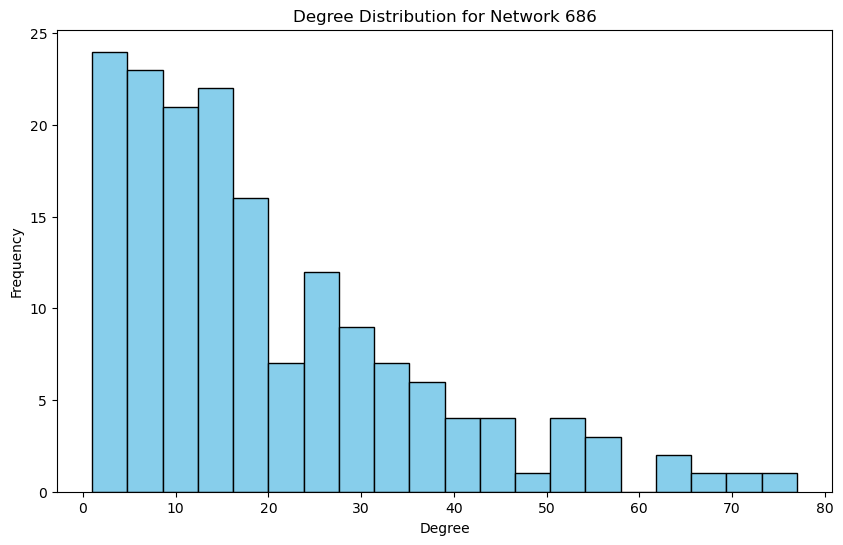

In [84]:
sample_network_id = list(ego_networks.keys())[0]  # Choose a sample network ID
sample_network = ego_networks[sample_network_id]

# Calculate degree for each node in the sample network
degrees = [degree for node, degree in sample_network.degree()]

# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title(f"Degree Distribution for Network {sample_network_id}")
plt.show()


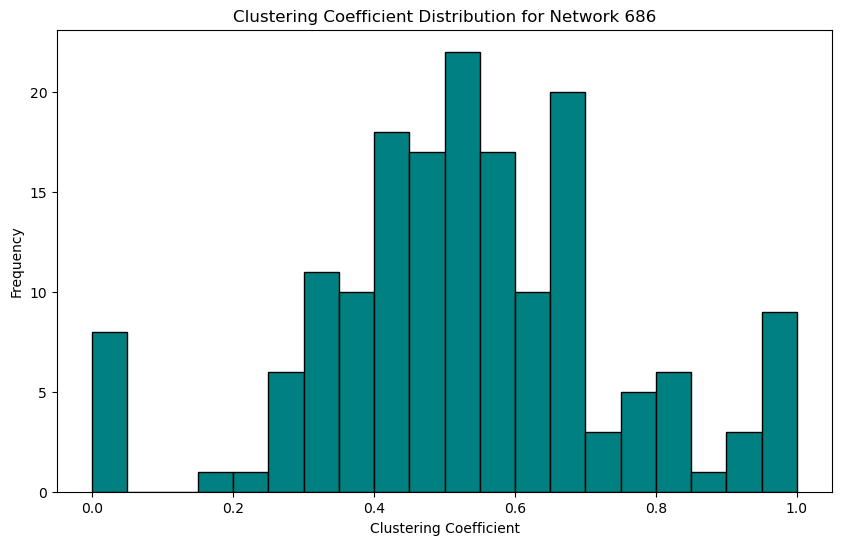

In [85]:
# Calculate clustering coefficients for the sample network
clustering_coeffs = list(nx.clustering(sample_network).values())

# Plot clustering coefficient distribution
plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=20, color='teal', edgecolor='black')
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title(f"Clustering Coefficient Distribution for Network {sample_network_id}")
plt.show()


In [80]:
# Extend the feature set with additional metrics for prediction
X = all_features_df[['degree', 'clustering', 'closeness', 'eigenvector']]
y = all_features_df['influential']  # Modify if predicting other attributes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00       694

    accuracy                           1.00      1227
   macro avg       1.00      1.00      1.00      1227
weighted avg       1.00      1.00      1.00      1227

Accuracy: 0.9991850040749797
